# Домашнее задание к лекции «Введение в сверточные НС»

In [2]:
import tensorflow as tf
from keras.datasets import cifar10

import numpy as np
import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

from tqdm.autonotebook import tqdm
import time

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import display

import warnings
warnings.filterwarnings('ignore')

#### Загрузка и визуализация данных

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10**4, random_state=42)

class_names = np.array(['airplane','automobile ','bird ','cat ','deer ','dog ','frog ','horse ','ship ','truck'])

print (X_train.shape,y_train.shape)

(40000, 32, 32, 3) (40000, 1)


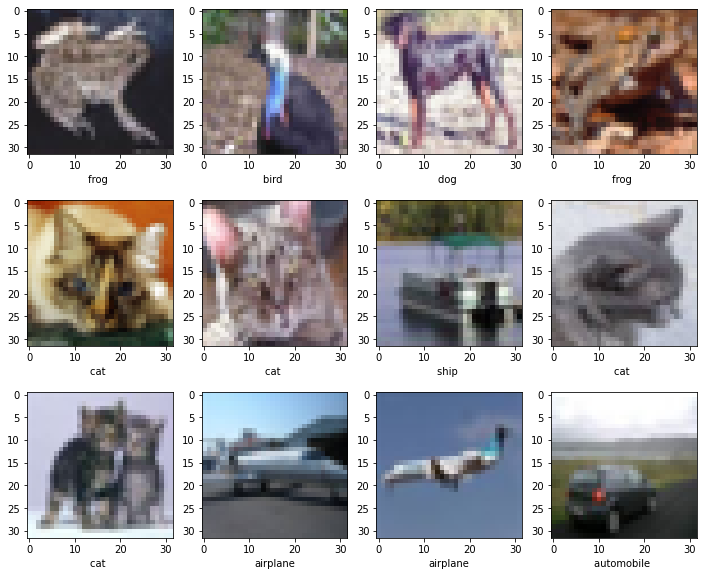

In [4]:
plt.figure(figsize=[12,10])
for i in range(12):
    plt.subplot(3, 4, i + 1)
    plt.xlabel(class_names[y_train[i, 0]])
    plt.imshow(X_train[i])

#### Подготовка и проверка данных

In [4]:
X_train = X_train / 255
X_val = X_val / 255
X_test = X_test / 255

In [35]:
assert np.shape(X_train) == (40000, 32, 32, 3), "data shape should not change"
assert 0.9 <= max(map(np.max, (X_train, X_val, X_test))) <= 1.05
assert 0.0 <= min(map(np.min, (X_train, X_val, X_test))) <= 0.1
assert len(np.unique(X_test / 255.)) > 10, "make sure you casted data to float type"

#### Вспомогательные функции

In [170]:
DEFAULT_LOSS = tf.keras.losses.SparseCategoricalCrossentropy()
DEFAULT_OPT = tf.keras.optimizers.SGD()

class TimeHistory(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)        
        
        
        
class stopAtAccValue(tf.keras.callbacks.Callback):
    def __init__(self, accuracy=0.85):
        self.accuracy = accuracy
        
    def on_epoch_end(self, epoch, logs={}):
        ACC = self.accuracy
            
        if logs.get('val_accuracy') >= ACC:
             self.model.stop_training = True
                

def fit_model(model, name='default', X=X_train, y=y_train,
              validation_data=(X_val, y_val), 
              metrics=["accuracy"],
              loss=DEFAULT_LOSS,
              optimizer=DEFAULT_OPT,              
              callbacks=[],
              **params
             ):
    
    model.compile(loss=loss, optimizer=optimizer, metrics=metrics)
    
    time_callback = TimeHistory()
    
    history = model.fit(X, y, validation_data=validation_data, verbose=0, callbacks=[time_callback, *callbacks], **params)
    
    H = history.history    
    loss = round(H['loss'][-1], 2)
    accuracy = round(H['accuracy'][-1], 2)
    val_loss = round(H['val_loss'][-1], 2)
    val_accuracy = round(H['val_accuracy'][-1], 2)
    times = time_callback.times
    
    res = pd.DataFrame(data=[[loss, accuracy], [val_loss, val_accuracy]],
                       index=['Train', 'Val'], columns=['Loss', 'Accuracy'])

    display(res)
    print('Mean runtime', round(np.mean(times), 1))
    print('Total runtime', round(sum(times), 1))
   
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    fig.suptitle('Learning curves')
    ax1.plot(H['loss'], color='blue')
    ax1.plot(H['val_loss'], color='red')
    ax1.set_title('Loss')
    ax1.legend(["train", 'val'])

    ax2.plot(H['accuracy'], color='blue')
    ax2.plot(H['val_accuracy'], color='red')
    ax2.set_title('Accuracy')
    ax2.legend(["train", 'val'])

    plt.show() 
    
def predict_model(model, count):
    y_pred = model.predict(X_test)
    y_pred_labels = np.argmax(y_pred, axis=1)
    
    test_acc = accuracy_score(y_test, y_pred_labels)
    
    print("\n Test_acc =", test_acc)
    assert test_acc > count, "Not good enough. Back to the drawing board :)"
    print(" Not bad!")   
    

## Задание 0

Для начала реализуйте простую нейросеть:
1. принимает на вход картинки размера 32 x 32 x 3;
2. вытягивает их в вектор (`keras.layers.Flatten`);
3. пропускает через 1 или 2 полносвязных слоя;
4. выходной слой отдает вероятности принадлежности к каждому из 10 классов.

In [97]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

,Loss,Accuracy
Train,1.58,0.44
Val,1.62,0.42


Mean runtime 2.9
Total runtime 29.3


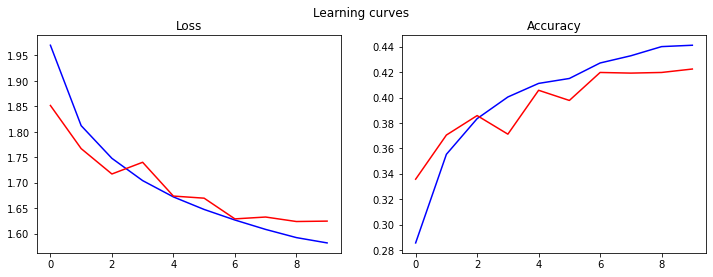

In [98]:
fit_model(model, batch_size=32, epochs=10)

Это наша стартовая модель. Её Accuracy на валидационной выборке 42%


<b><i>Примечание</i></b>: Я частично поменяла проверочный код из домашнего задания, так как у модели Sequential больше нет методов predict_proba и predict_classes, рекомендуется исполозовать predict.

In [99]:
dummy_pred = model.predict(X_train[:20])
assert dummy_pred.shape == (20, 10)
assert np.allclose(dummy_pred.sum(-1), 1)
print("Успех!")

Успех!


## Задание 1 (обязательно) 

Будем минимизировать многоклассовую кроссэкнропию с помощью __sgd__. Вам нужно получить сеть, которая достигнет __не менее 45%__ __accuracy__ на тестовых данных.

Добавим в нашу модель ещё один слой, снизим скорость обучения до 0.01, настроим коллбек ранней остановки и увеличим кол-во эпох до 100.

In [149]:
model = tf.keras.Sequential(
    [
        tf.keras.layers.Flatten(input_shape=(32, 32, 3)),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(32, activation="relu"),
        tf.keras.layers.Dense(10, activation="softmax"),
    ]
)

In [150]:
stopping_lr = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

,Loss,Accuracy
Train,1.47,0.48
Val,1.55,0.45


Mean runtime 3.6
Total runtime 68.0


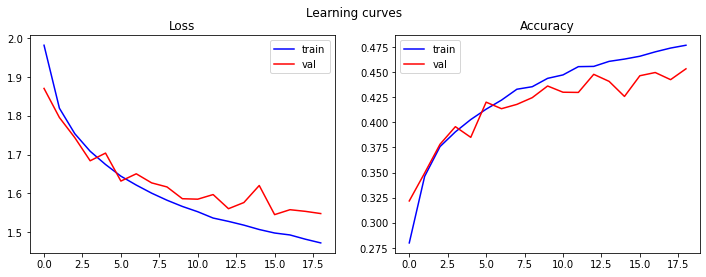

In [151]:
fit_model(model, name='task1', 
          optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), batch_size=32, epochs=100, callbacks=[stopping_lr])

In [152]:
predict_model(model, 0.45)


 Test_acc = 0.4513
 Not bad!


Заданный порог пройден, обучение остановлено на 18-ой эпохе, есть некритичное переобучение

## Задание 2 (обязательно) Реализуйте небольшую свёрточную сеть. Совсем небольшую:

1. Входной слой
2. Свёртка 3x3 с 10 фильтрами
3. Нелинейность на ваш вкус
4. Max-pooling 2x2
5. Вытягиваем оставшееся в вектор (Flatten)
6. Полносвязный слой на 100 нейронов
7. Нелинейность на ваш вкус
8. Выходной полносвязный слой с softmax

Обучите её так же, как и предыдущую сеть. Если всё хорошо, у вас получится accuracy не меньше __50%__.

In [155]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

,Loss,Accuracy
Train,0.98,0.66
Val,1.21,0.58


Mean runtime 4.6
Total runtime 77.8


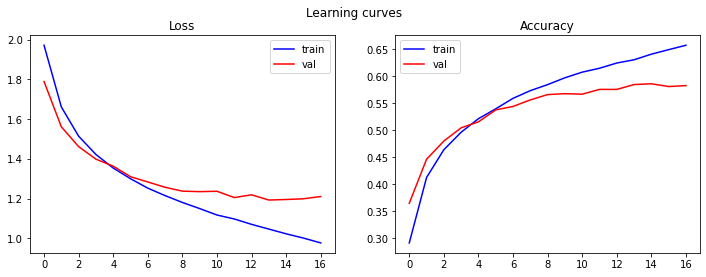

In [156]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), batch_size=32, epochs=100, callbacks=[stopping_lr])

In [157]:
predict_model(model, 0.50)


 Test_acc = 0.5763
 Not bad!


Модель прилично переобучилась, но нужный порог преодолела. Можно было остановиться на 5/6 эпохе

## Задание 3 (опционально)

Попробуйте использовать различные методы оптимизации (sgd, momentum, adam) с параметрами по умолчанию. Какой из методов работает лучше?

Так как здесь мы сравниваем работу оптимайзеров, то будем работать с параметрами по умолчанию и запустим обучение на 20 эпох без дополнительных колбеков

SGD


,Loss,Accuracy
Train,0.89,0.69
Val,1.19,0.59


Mean runtime 4.4
Total runtime 87.6


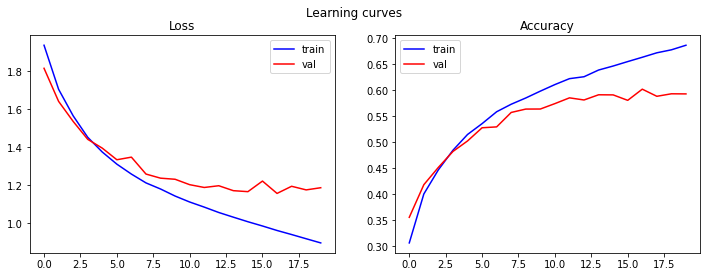

Adam


,Loss,Accuracy
Train,0.66,0.77
Val,1.30,0.60


Mean runtime 4.9
Total runtime 98.2


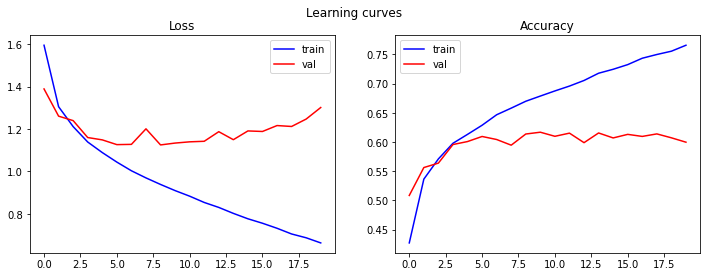

RMSprop


,Loss,Accuracy
Train,0.56,0.8
Val,1.47,0.6


Mean runtime 5.9
Total runtime 118.5


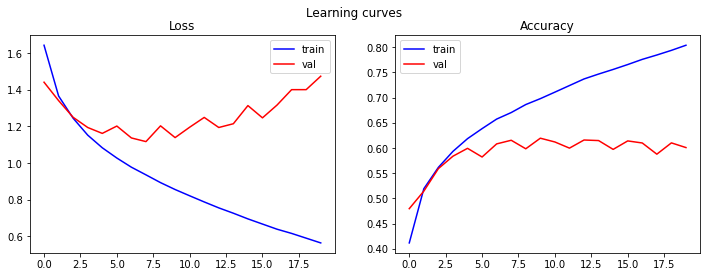

Adadelta


,Loss,Accuracy
Train,2.13,0.27
Val,2.12,0.26


Mean runtime 4.8
Total runtime 96.6


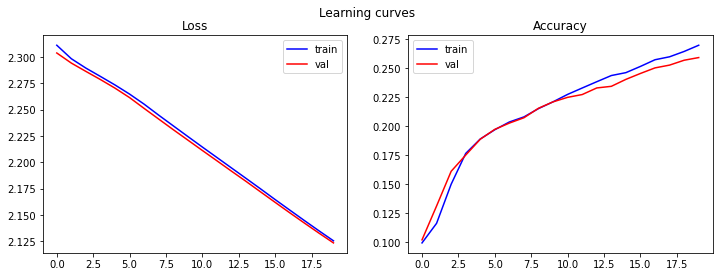

Adagrad


,Loss,Accuracy
Train,1.54,0.47
Val,1.55,0.46


Mean runtime 4.3
Total runtime 85.1


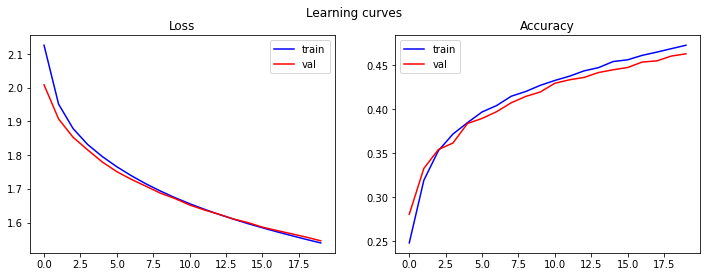

Adamax


,Loss,Accuracy
Train,0.76,0.74
Val,1.11,0.63


Mean runtime 4.6
Total runtime 92.7


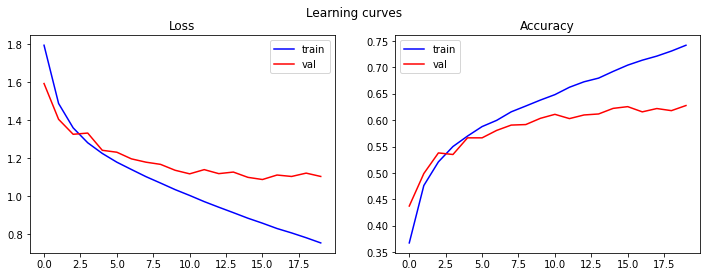

Nadam


,Loss,Accuracy
Train,0.42,0.85
Val,1.51,0.61


Mean runtime 7.3
Total runtime 146.0


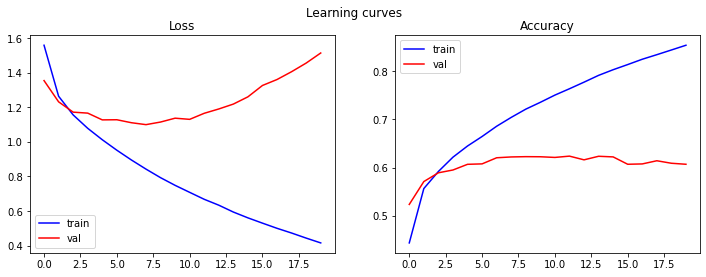

In [183]:
optimizers = {
    'SGD': tf.keras.optimizers.SGD(),
    'Adam': tf.keras.optimizers.Adam(),
    'RMSprop': tf.keras.optimizers.RMSprop(),
    'Adadelta': tf.keras.optimizers.Adadelta(),
    'Adagrad': tf.keras.optimizers.Adagrad(),
    'Adamax': tf.keras.optimizers.Adamax(),
    'Nadam': tf.keras.optimizers.Nadam(),
}

for name, opt in optimizers.items():
    model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])
    
    print(name)
    fit_model(model, optimizer=opt, batch_size=32, epochs=20)

In [189]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

,Loss,Accuracy
Train,1.34,0.54
Val,1.39,0.52


Mean runtime 4.5
Total runtime 2274.2


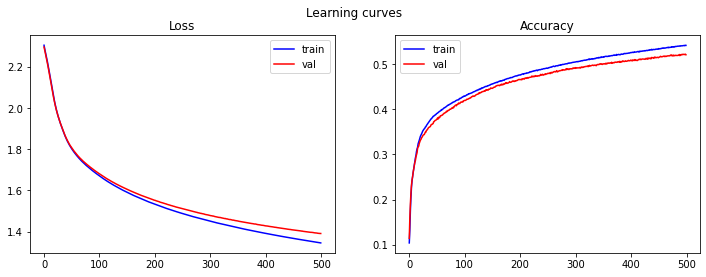

In [190]:
fit_model(model, optimizer=tf.keras.optimizers.Adadelta(), batch_size=32, epochs=500, callbacks=[stopping_lr])

Выводы по метрикам и графикам:

    1. За 20 эпох все протестированные оптимизаторы, кроме Adadelta и Adagrad дают примерно одинаковую точность на валидационной выборке (около 60%). Лучший результат у Adamax - 63%. При этом:
    - модель медленнее переобучается на SGD. Средний результат у Adamax
    - Adam, RMSprop и Nadam переобучаются очень быстро. Разница между ними в том, что Nadam "стартует" с лучшего значения и достигает итоговой точности быстрее. Все три алгоритма дают точность в районе 60% уже к 5-ой эпохе
    2. Adadelta и Adagrad обучаются очень медленно (по умолчанию их learning_rate 0.001), на 20-ти эпохах кривые обучения и валидации почти сливаются, поэтому на таком коротком отрезке и без дополнительных настроек их качесвто оценить нельзя. Я запустила Adadelta на 500 эпох (последний график) и картина не изменилась.

## Задание 4 (опционально)

Добавьте нормализацию по батчу (`BatchNormalization`) между свёрткой и активацией. Попробуйте использовать несколько нормализаций — в свёрточных и полносвязных слоях. Прокомментируйте полученные результаты.

Здесь я не буду использовать раннюю остановку, чтобы посмотреть, как ведёт себя модель на отрезке в 25 эпох  

In [22]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

,Loss,Accuracy
Train,0.09,0.98
Val,2.64,0.59


Mean runtime 4.8
Total runtime 120.3


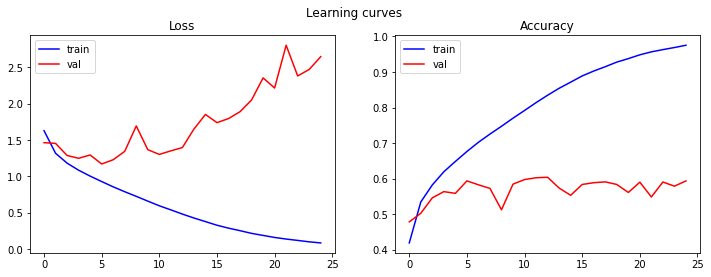

In [23]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), batch_size=32, epochs=25)

После добавления слоя BatchNormalization сеть обучается быстрее (достигает пикового значения за меньшее кол-во эпох), и также быстро переобучается. 

Добавим ещё слой BatchNormalization после полносвязного слоя

In [24]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

,Loss,Accuracy
Train,0.34,0.89
Val,1.46,0.60


Mean runtime 5.8
Total runtime 145.3


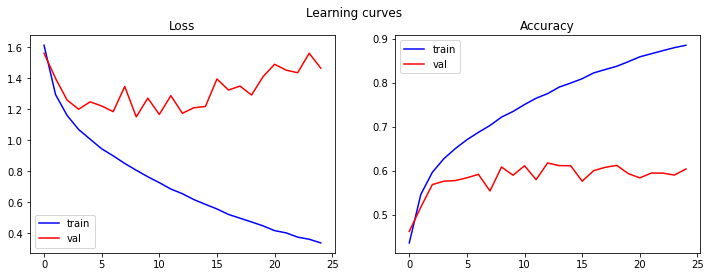

In [25]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), batch_size=32, epochs=25)

Здесь заметно снизился рост loss при переобучении, а также немного снизилось итоговое переобучение

## Задание 5 (опционально) 

Посмотрите на batch_size (параметр model.fit) - при большем батче модель будет быстрее проходить эпохи, но с совсем огромным батчом вам потребуется больше эпох для сходимости (т.к. сеть делает меньше шагов за одну эпоху). Найдите такое значение, при котором модель быстрее достигает точности 55%. Hint: используйте early stopping callback.

Здесь я для чистоты эксперимента буду использовать модель без BatchNormalization. Сначала попробуем <b>batch_size=32</b>

In [62]:
model = tf.keras.models.Sequential([
        tf.keras.layers.Conv2D(filters=10, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

In [55]:
stop_callback = stopAtAccValue(accuracy=0.55)

,Loss,Accuracy
Train,1.27,0.55
Val,1.27,0.55


Mean runtime 4.3
Total runtime 25.7


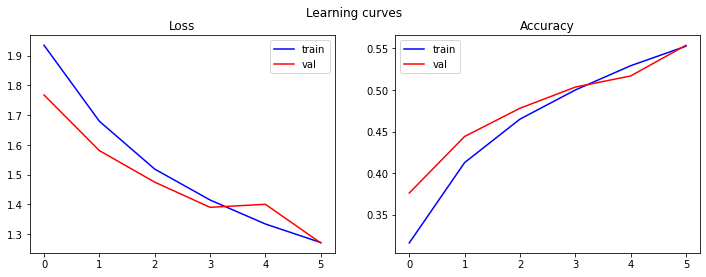

In [56]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), batch_size=32, epochs=25, callbacks=[stop_callback])

Здесь понадобилось 5 эпох и 26 секунд. 

Попробуем уменьшить: <b>batch_size=16</b>

,Loss,Accuracy
Train,1.19,0.58
Val,1.21,0.57


Mean runtime 8.1
Total runtime 40.6


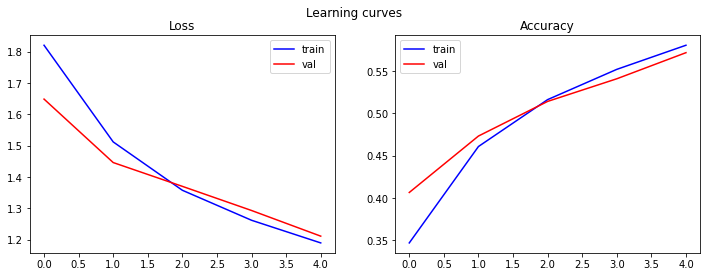

In [58]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), batch_size=16, epochs=25, callbacks=[stop_callback])

Кол-во эпох сократилось, но время выросло: 4 эпохи и 41 секунда.

<b>batch_size=64:</b>

,Loss,Accuracy
Train,1.21,0.57
Val,1.25,0.56


Mean runtime 2.2
Total runtime 31.3


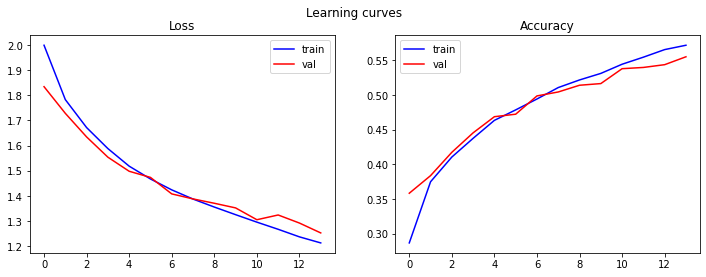

In [61]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), batch_size=64, epochs=25, callbacks=[stop_callback])

А тут кол-во эпох резко пошло вверх, понадобилось 13 эпох. Время на эпоху действительно сократилось (2.2s), но из-за того, что их стало больше, общее время хуже, чем у 32

<b>batch_size=128:</b>

,Loss,Accuracy
Train,1.16,0.59
Val,1.26,0.55


Mean runtime 1.4
Total runtime 35.4


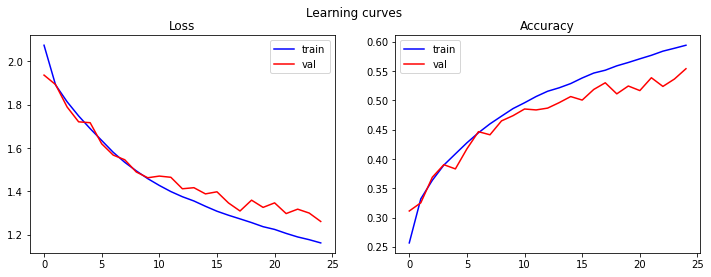

In [63]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), batch_size=128, epochs=50, callbacks=[stop_callback])

Здесь подтверждаются предыдущие выводы. Одна эпоха обучается быстрее, но из-за того, что кол-во эпох резко возрастает, общее время выше, чем batch_size=32.

Ответ на вопрос "Найдите такое значение, при котором модель быстрее достигает точности 55%": batch_size=32. В моём случае общее время обучения 25.7s

## Задание 1.6 (опционально) 

Попробуйте найти такую комбинацию метода обучения и нормализации, при которой сеть имеет наилучшую кривую обучения. Поясните, что вы понимаете под "наилучшей" кривой обучения.

Под лучшей кривой обучения я понимаю кривую, которая не имеет признаков переобучения или недообучения, то есть разрыв между линиями обучения и валидации минимален. 

Этот пункт я пропускаю. Я сделала несколько тестов и на мой взгляд результаты неудовлетворительные. Нормализация без дропаута очень сильно переобучается (а эксперименты с дропаутом будут в следующем задании)

### Вопрос
Я правильно понимаю понятие наилучшей кривой обучения?

## Задание 1.7 (обязательно попытаться)

Наигравшись выше, обучим большую свёрточную сеть, которая даст на тестовой выборке __accuracy больше 80%__. В этом задании вам потребуется провести эксперименты, сравнив их между собой в конце. Возможно, может быть несколько проще, если писать выводы во время или сразу после каждого эксперимента, после чего сделать общие выводы.

В качестве основы я буду использовать эту модель из предыдущих заданий. Будем обучать 30 эпох, но остановим, если достигнем точности больше 85% на валидации (не ставлю 80, так как хотелось бы иметь запас).

Чтобы не раздувать ДЗ ещё больше, здесь собраны в основном удачные варианты.

Для начала я попробую использовать не 10, а 32 фильтра в сверточном слое.

In [105]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

,Loss,Accuracy
Train,0.08,0.98
Val,1.81,0.61


Mean runtime 5.7
Total runtime 171.6


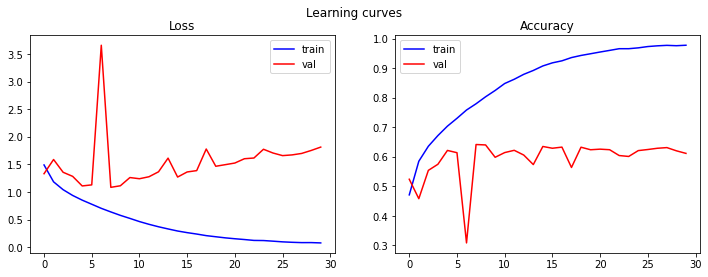

In [106]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), batch_size=32, epochs=30, callbacks=[stopAtAccValue()])

Выглядит не очень хорошо. Точность не прибавилась, переобучение очень сильное, а loss на валидации только увеличивалась.

Попробуем добавить ещё один блок со сверткой, нормализацией и пулингом 

In [108]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),    
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),   
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

,Loss,Accuracy
Train,0.15,0.95
Val,1.34,0.67


Mean runtime 7.0
Total runtime 209.0


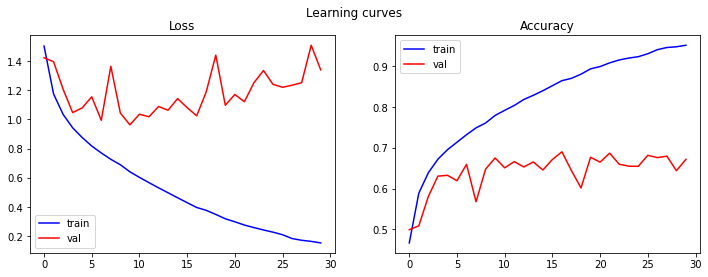

In [109]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), batch_size=32, epochs=30, callbacks=[stopAtAccValue()])

Точность повысилась до 67, но все ещё сильные  проблемы с переобучением

Теперь попробуем увеличить кол-во фильтров на втором слое в 2 раза

In [112]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),    
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),   
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

,Loss,Accuracy
Train,0.05,0.99
Val,1.62,0.66


Mean runtime 7.1
Total runtime 213.7


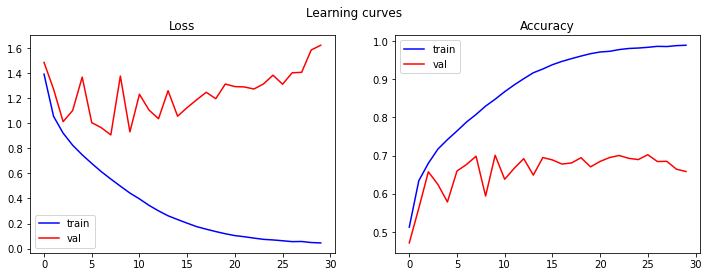

In [113]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), batch_size=32, epochs=30, callbacks=[stopAtAccValue()])

Изменений не видно, вернусь к предыдущему варианту на 32 и добавлю ещё блок

In [114]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),    
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),   
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'), 
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

,Loss,Accuracy
Train,0.39,0.86
Val,0.94,0.71


Mean runtime 8.9
Total runtime 268.4


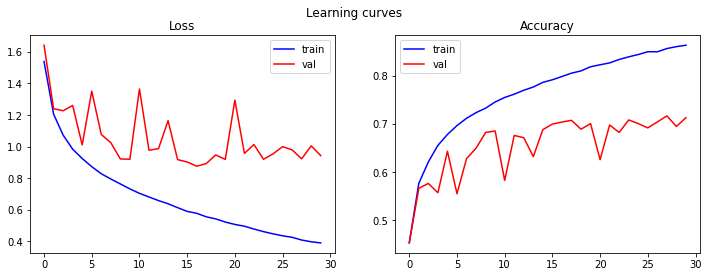

In [115]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), batch_size=32, epochs=30, callbacks=[stopAtAccValue()])

А вот тут есть хороший прирост, оставляем. 

Увеличим кол-во фильтров в полносвязном слое (берём всё, кратно 32, но так как 128 от 100 отличается несильно, пусть будет сразу 256).

In [120]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),    
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),   
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'), 
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(10, activation='softmax')
])

,Loss,Accuracy
Train,0.25,0.92
Val,1.08,0.70


Mean runtime 8.5
Total runtime 256.5


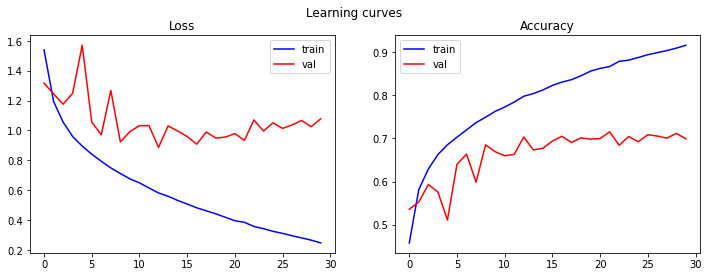

In [121]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), batch_size=32, epochs=30, callbacks=[stopAtAccValue()])

Стало хуже. Вернёмся к 128. Попробуем добавить небольшой Dropout после каждого слоя

In [123]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),  
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'), 
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'), 
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

,Loss,Accuracy
Train,0.85,0.70
Val,0.83,0.71


Mean runtime 9.1
Total runtime 272.6


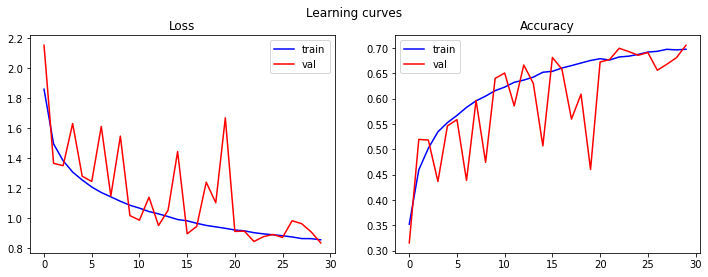

In [124]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), batch_size=32, epochs=30, callbacks=[stopAtAccValue()])

Ухх) Результат не изменился, но решилась проблема с переобучением. Ещё появился вывод, что при использовании дропаута может быть неоправдано ставить раннюю остановку, завязанную на изменение val_loss/val_метрик, особенно с маленьким patience, модель будет останавливаться слишком быстро. В принципе теперь я вижу, что идея ставить остановку на валидационную выборку изначально провальная, надо ставить на train

Попробуем повысить качество с помощью настроек оптимизатора. Я буду так же использовать SDG, так как в экспериментах выше он хорошо зарекомендовал себя "из коробки" по соотношению качество/скорость/склонность к переобучению

In [125]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),  
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'), 
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'), 
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

,Loss,Accuracy
Train,0.72,0.74
Val,0.72,0.75


Mean runtime 9.9
Total runtime 296.6


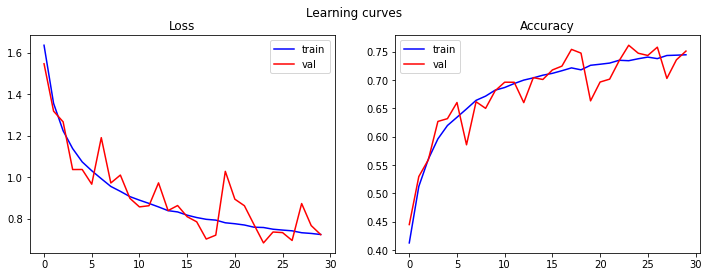

In [126]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
          batch_size=32, epochs=30, callbacks=[stopAtAccValue()])

Результат заметно выше. Попробуем увеличивать кол-во фильтров

In [127]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),  
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'), 
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'), 
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(10, activation='softmax')
])

,Loss,Accuracy
Train,0.36,0.87
Val,0.68,0.79


Mean runtime 10.5
Total runtime 315.1


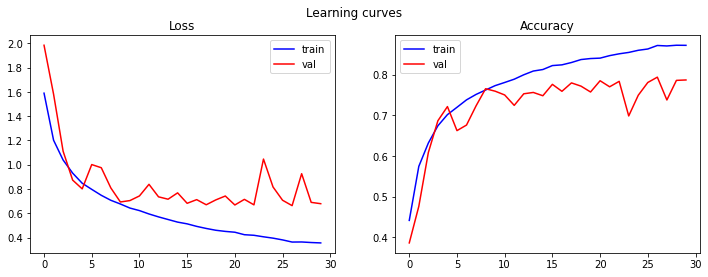

In [128]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
          batch_size=32, epochs=30, callbacks=[stopAtAccValue()])

Почти... Попробуем увеличить последний дропаут

In [134]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),  
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'), 
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'), 
    tf.keras.layers.Dropout(0.2),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

,Loss,Accuracy
Train,0.52,0.82
Val,0.60,0.80


Mean runtime 9.3
Total runtime 280.2


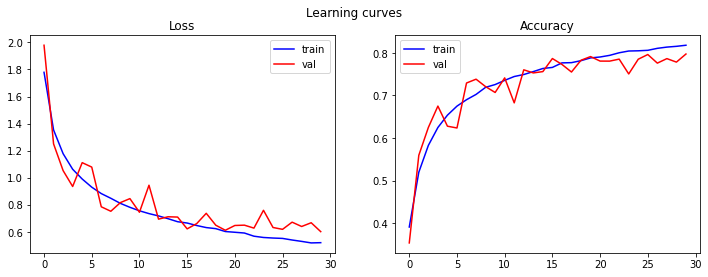

In [135]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
          batch_size=32, epochs=30, callbacks=[stopAtAccValue()])

Казалось бы, вот оно счастье), но как видно ниже, на тестовой выборке результат чуть меньше:

In [136]:
predict_model(model, 0.8)


 Test_acc = 0.7955


AssertionError: Not good enough. Back to the drawing board :)

Увеличила кол-во эпох и остановку поставила остановку на 80

In [150]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),  
    tf.keras.layers.Dropout(0.20),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'), 
    tf.keras.layers.Dropout(0.20),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'), 
    tf.keras.layers.Dropout(0.20),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

,Loss,Accuracy
Train,0.49,0.83
Val,0.60,0.80


Mean runtime 9.1
Total runtime 328.7


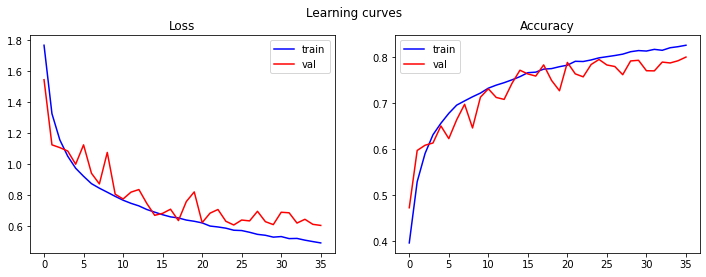

In [151]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
          batch_size=32, epochs=50, callbacks=[stopAtAccValue(accuracy=0.8)])

In [152]:
predict_model(model, 0.8)


 Test_acc = 0.7994


AssertionError: Not good enough. Back to the drawing board :)

Мне кажется выжать из такой архитектуры больше не получится. Даже если какой-то вариант и даст 80% на тесте, это все ещё нестабильно. Попробуем добавить ещё слоёв:

In [156]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),  
    tf.keras.layers.Dropout(0.20),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'), 
    tf.keras.layers.Dropout(0.20),
    
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'), 
    tf.keras.layers.Dropout(0.20),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

,Loss,Accuracy
Train,0.13,0.95
Val,0.68,0.83


Mean runtime 12.6
Total runtime 632.2


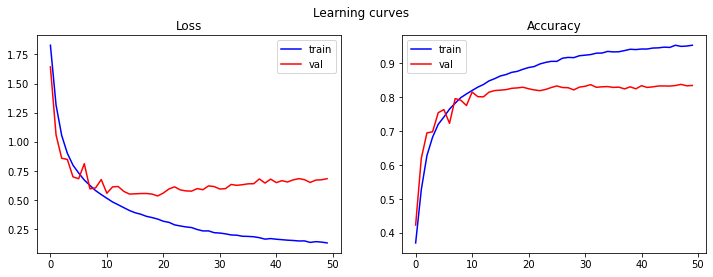

In [157]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
          batch_size=32, epochs=50, callbacks=[stopAtAccValue()])

In [158]:
predict_model(model, 0.8)


 Test_acc = 0.8328
 Not bad!


Супер. Модель переобучилась, можно поставить остановку на 80 или взять меньше эпох (хватит 10-15), но даже так результат достигнут. Дальнейшие эксперименты показали, что третий блок можно и убрать:

In [171]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'),  
    tf.keras.layers.Dropout(0.20),
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPool2D(pool_size=(2, 2), padding='same'), 
    tf.keras.layers.Dropout(0.20),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(10, activation='softmax')
])

,Loss,Accuracy
Train,0.35,0.88
Val,0.60,0.81


Mean runtime 10.4
Total runtime 229.5


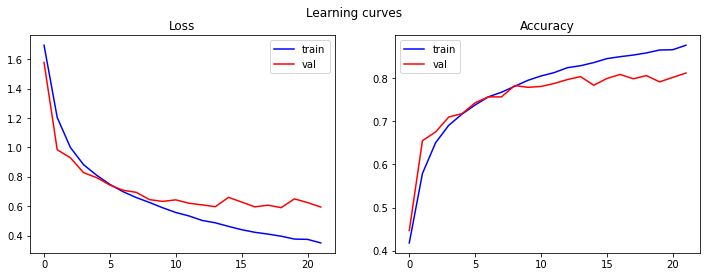

In [172]:
fit_model(model, optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True),
          batch_size=32, epochs=50, callbacks=[stopAtAccValue(accuracy=0.81)])

In [173]:
predict_model(model, 0.8)


 Test_acc = 0.8056
 Not bad!


Эта модель достаточно быстрая и менее переобученая, на ней и остановлюсь.

"А теперь, опишите свои ощущения/результаты от проведенных экспериментов."

Результаты я подробно описывала после каждого эксперимента, поэтому не буду повторяться. А что касается ощущений, то:

    1. Настройка GPU - необходимость, которая экономит огромное кол-во времени
    2. Обучать нейросеть интересно в первую очередь результатом
    3. Обучать нейросеть долго, несмотря на пункт первый
    4. Буду благодарна за наводку на хороший ресурс, где можно почитать про выбор архитектуры. 